# XGBoost 

In [1]:
import warnings
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
df = pd.read_csv("Financial_Mexican_Firms.csv")

1. Train & Split 

In [2]:
X  = df.iloc[:, 0:10]
y  = df.iloc[:, 10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0) 
df_train = pd.concat([X_train, y_train], axis = 1)
df_test  = pd.concat([X_test, y_test], axis = 1)

2. Handling missing values

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Imputation techniques
iregression_imputer = IterativeImputer(estimator = LinearRegression(), 
                                   missing_values = np.nan, 
                                   max_iter = 5, 
                                   imputation_order = 'roman', 
                                   random_state = 0)

# Apply an Imputation technique for training & testing datasets and rename columns
df_train  = pd.DataFrame(iregression_imputer.fit_transform(df_train), columns = ['ProposedIndex', 
                                                                 'IIHH',  
                                                                 'Shannon',
                                                                 'Size',
                                                                 'AssetTurnover',
                                                                 'Debt',
                                                                 'QuickRatio',
                                                                 'CashHoldings',
                                                                 'ROE',
                                                                 'ROI',
                                                                 'ROA'])

df_test  = pd.DataFrame(iregression_imputer.fit_transform(df_test), columns = ['ProposedIndex', 
                                                                 'IIHH',  
                                                                 'Shannon',
                                                                 'Size',
                                                                 'AssetTurnover',
                                                                 'Debt',
                                                                 'QuickRatio',
                                                                 'CashHoldings',
                                                                 'ROE',
                                                                 'ROI', 
                                                                 'ROA'])

# Update the training set
X_train  = df_train.iloc[:,:-1]
y_train  = df_train.ROA

X_test  = df_test.iloc[:,:-1]
y_test  = df_test.ROA

3. Feature Importance 

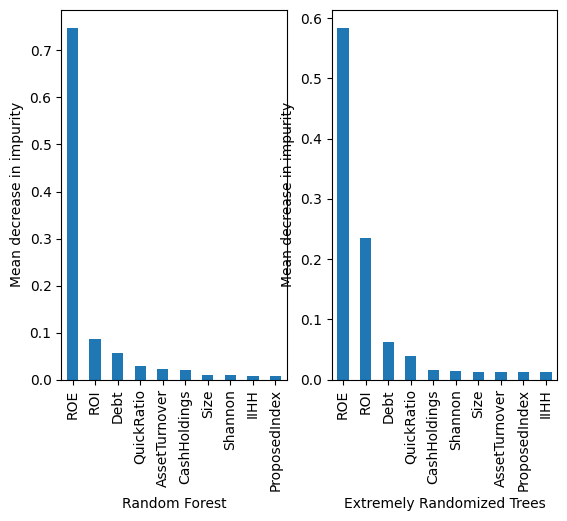

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

rf   = RandomForestRegressor().fit(X_train, y_train)
tree = ExtraTreesRegressor().fit(X_train, y_train)

series_importance_rf   = pd.Series(rf.feature_importances_,   index = X_train.columns)
series_importance_tree = pd.Series(tree.feature_importances_, index = X_train.columns)

plt.subplot(1,2,1)
series_importance_rf.nlargest(10).plot.bar()
plt.xlabel('Random Forest')
plt.ylabel('Mean decrease in impurity')

plt.subplot(1,2,2)
series_importance_tree.nlargest(10).plot.bar()
plt.xlabel('Extremely Randomized Trees')
plt.ylabel('Mean decrease in impurity')
plt.show()

4. Hyperparameter Tunning

In [5]:
# Specify different values for the tunning process
kfold = KFold(n_splits = 5, random_state = None, shuffle = False)

#n_estimators     = [int(x) for x in np.linspace(start = 50, stop = 250, num = 50)]
learning_rate    = [round(float(x), 2) for x in np.linspace(start = .05, stop = .5, num = 10)]
max_depth        = [int(x) for x in np.linspace(1, 10, num = 5)]
min_child_weight = [1, 3, 5]
gamma            = [0.0, 0.1, 0.3]
reg_lambda       = [0, 1, 5 ]
colsample_bytree = [0.3, 0.5 , 0.7 ]

#Create parameter grid
params={
    #"n_estimators"     : n_estimators,  
    "learning_rate"    : learning_rate ,
    "max_depth"        : max_depth,
    "min_child_weight" : min_child_weight,
    "gamma"            : gamma,
    "reg_lambda"       : reg_lambda,
    "colsample_bytree" : colsample_bytree}

#Create XGBoost object
model = XGBRegressor()

#Grid Search CV
search = GridSearchCV(model, 
                      params, 
                      scoring = 'r2', 
                      cv = kfold, 
                      n_jobs = -1)

5. Fit the model and measure time to execute

In [6]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
start_time = timer(None) # timing starts from this point for "start_time" variable
search.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 4 minutes and 26.64 seconds.


6. Get best tunning paratemers 

In [7]:
search.best_estimator_
search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 1,
 'reg_lambda': 1}

7. Specify the optimal model

In [8]:
optimal_model = XGBRegressor(colsample_bytree = 0.7,
                            learning_rate     = 0.2,
                            max_depth         = 7, 
                            min_child_weight  = 1,
                            reg_lambda        = 1).fit(X_train, y_train)

8. Evaluate performance

In [9]:
import time
start_time = time.time()

y_pred     = optimal_model.predict(X_test)
    
print('R2  :', r2_score(y_test, y_pred))
print('MAE :', mean_absolute_error(y_test, y_pred))
print('MSE :', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Processing time: %s seconds' % round((time.time() - start_time), 4))

# Categorical scoring 
# ‘accuracy’
# ‘balanced_accuracy’
# ‘roc_auc’
# ‘f1’
# Continuous scoring
# ‘neg_mean_absolute_error’
# ‘neg_root_mean_squared_error’
# ‘r2’


R2  : 0.7919737714064254
MAE : 0.01613776080831885
MSE : 0.000897910242206227
RMSE: 0.029965150461932058
Processing time: 0.006 seconds


9. Deployment

In [10]:
import pickle
#Open a file, where you want to store data
file = open("XGBoost_diversification.pkl", 'wb')
#Dump information to that file
pickle.dump(optimal_model, file)